In [1]:
%cd /capstor/scratch/cscs/ckuya/

/capstor/scratch/cscs/ckuya


In [28]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn


## Keyword spotting

## Data Exploration

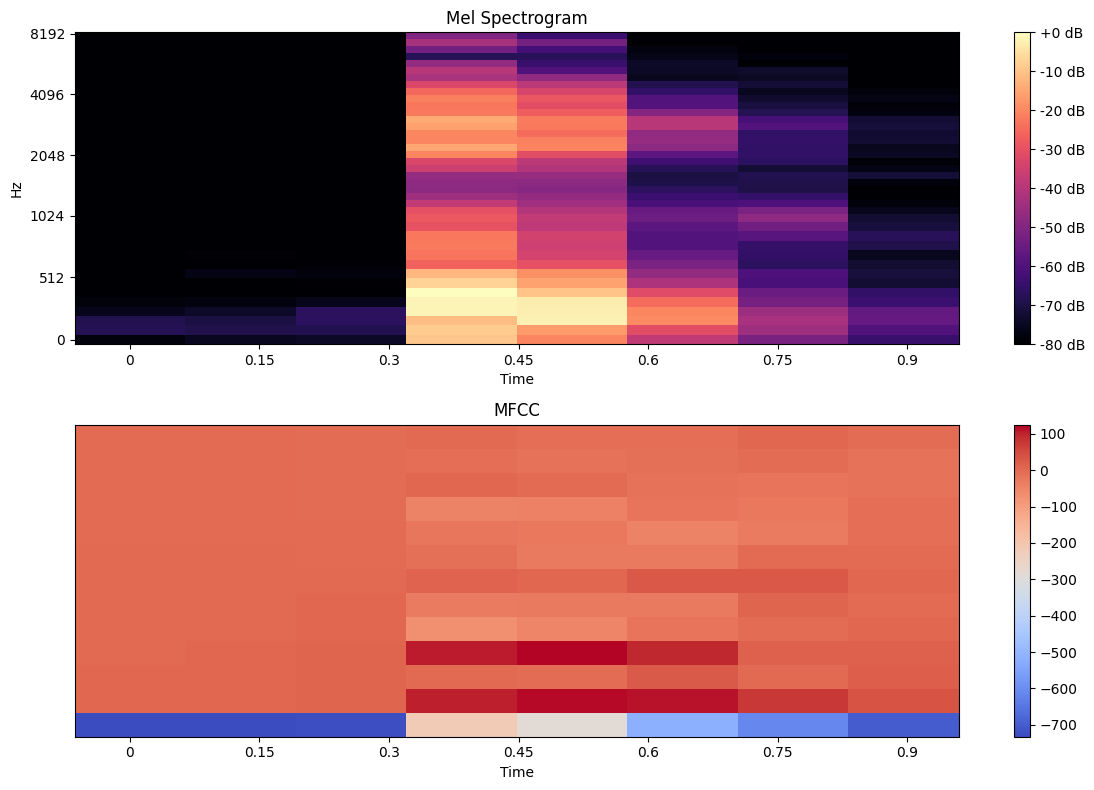

In [4]:

# Load audio
y, sr = librosa.load('/capstor/scratch/cscs/ckuya/speech-data/test/audio/clip_ef44e3828.wav', sr=16000)

# Parameters
n_fft = 2048 
hop_percent = 0   
win_length = 2048   
hop_length = round(win_length * (1-hop_percent)) 
window = 'hann'     
n_mels = 40        
n_mfcc = 13        

# Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    n_mels=n_mels
)

# MFCC
mfcc = librosa.feature.mfcc(
    y=y, sr=sr,
    n_mfcc=n_mfcc,
    n_fft=n_fft,
    hop_length=hop_length,
    window=window
)

# Visualization
plt.figure(figsize=(12, 8))

# Mel Spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(
    librosa.power_to_db(mel_spec, ref=np.max),
    x_axis='time',
    y_axis='mel',
    sr=sr,
    hop_length=hop_length
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

# MFCC
plt.subplot(2, 1, 2)
librosa.display.specshow(
    mfcc,
    x_axis='time',
    sr=sr,
    hop_length=hop_length
)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


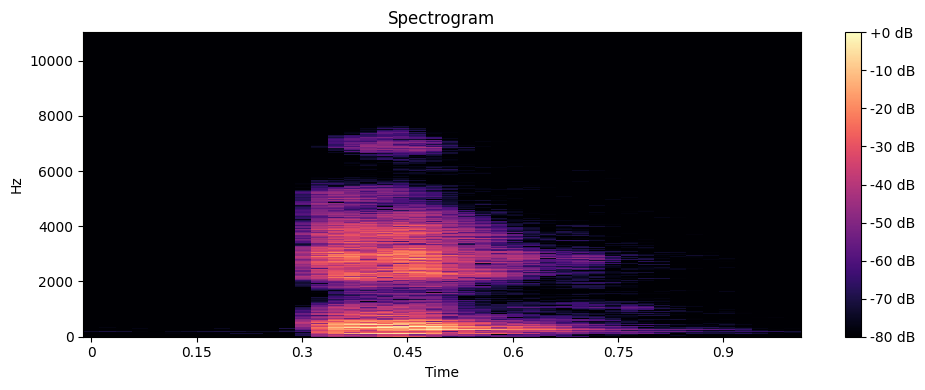

In [5]:


# Load 60-second audio
y, sr = librosa.load('/capstor/scratch/cscs/ckuya/speech-data/test/audio/clip_ef44e3828.wav', duration=60)

# Parameters
n_fft = 2048
hop_length = 512
window = 'hann'

# Compute STFT (spectrogram)
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)

# Convert to amplitude (or power) spectrogram
S = np.abs(D)**2

# Display
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='hz')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


## Model 

In [38]:
class SBU_LSTM_AudioClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_bd_layers=1, 
                 num_middle_layers=1, dropout=0.3, bidirectional_middle=False):
        """
        SBU-LSTM model for audio classification based on the paper architecture.
        
        Args:
            input_dim: Number of input features (e.g., mel spectrogram bins)
            hidden_dim: Hidden dimension size for LSTM layers
            num_classes: Number of output classes
            num_bd_layers: Number of initial bidirectional LSTM layers
            num_middle_layers: Number of middle layers (optional in the paper)
            dropout: Dropout rate
            bidirectional_middle: Whether middle layers are bidirectional or unidirectional
        """
        super().__init__()
        
        # Masking for handling missing values (as described in the paper)
        self.supports_masking = True
        
        # First layer(s): Bidirectional LSTM (required by the paper architecture)
        self.bd_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_bd_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_bd_layers > 1 else 0
        )
        
        # Middle layers (optional in the paper)
        self.middle_layers = nn.ModuleList()
        middle_input_dim = hidden_dim * 2  # Output from bidirectional layer
        
        for i in range(num_middle_layers):
            if bidirectional_middle:
                # Bidirectional middle layers
                self.middle_layers.append(
                    nn.LSTM(
                        input_size=middle_input_dim if i == 0 else hidden_dim * 2,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=True,
                        dropout=0
                    )
                )
            else:
                # Unidirectional middle layers
                self.middle_layers.append(
                    nn.LSTM(
                        input_size=middle_input_dim if i == 0 else hidden_dim,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=False,
                        dropout=0
                    )
                )
                middle_input_dim = hidden_dim
        
        # Final layer: Unidirectional LSTM (required by the paper architecture)
        final_input_dim = hidden_dim * 2 if (bidirectional_middle and num_middle_layers > 0) else hidden_dim
        if num_middle_layers == 0:
            final_input_dim = hidden_dim * 2  # Directly from first BD-LSTM
            
        self.uni_lstm = nn.LSTM(
            input_size=final_input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        
        # Attention mechanism (as used in the paper)
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Output classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, lengths=None):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            lengths: Optional sequence lengths for packed sequence processing
        
        Returns:
            Classification logits of shape (batch_size, num_classes)
        """
        # Handle variable length sequences if provided
        if lengths is not None:
            # Pack padded sequence
            x_packed = nn.utils.rnn.pack_padded_sequence(
                x, lengths, batch_first=True, enforce_sorted=False
            )
            
            # First bidirectional LSTM layer(s)
            out_packed, _ = self.bd_lstm(x_packed)
            
            # Unpack sequence
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            # First bidirectional LSTM layer(s)
            out, _ = self.bd_lstm(x)
        
        # Middle layers (if any)
        for layer in self.middle_layers:
            if lengths is not None:
                out_packed = nn.utils.rnn.pack_padded_sequence(
                    out, lengths, batch_first=True, enforce_sorted=False
                )
                out_packed, _ = layer(out_packed)
                out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
            else:
                out, _ = layer(out)
        
        # Final unidirectional LSTM layer
        if lengths is not None:
            out_packed = nn.utils.rnn.pack_padded_sequence(
                out, lengths, batch_first=True, enforce_sorted=False
            )
            out_packed, (h_n, _) = self.uni_lstm(out_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, (h_n, _) = self.uni_lstm(out)
        
        # Apply attention mechanism (as in the paper)
        attention_weights = F.softmax(self.attention(out), dim=1)
        context = torch.sum(attention_weights * out, dim=1)
        
        # Apply dropout and final classification layer
        context = self.dropout(context)
        logits = self.fc(context)
        
        return logits


## Training 

In [30]:
class AudioFeatureDataset(Dataset):
    def __init__(self, root_dir, sr=16000, n_fft=2048, hop_percent=0.5, 
                 win_length=2048, n_mels=40, n_mfcc=13, max_len=None):
        self.root_dir = root_dir
        self.samples = []
        self.label_to_idx = {}
        
        # Audio processing parameters
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = round(win_length * (1-hop_percent))
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        
        self._prepare_dataset()
        
    def _prepare_dataset(self):
        # Assign an integer index to each label (folder name)
        labels = sorted([d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))])
        self.label_to_idx = {label: idx for idx, label in enumerate(labels)}
        
        # Walk through each folder and collect file paths and labels
        for label in labels:
            folder_path = os.path.join(self.root_dir, label)
            for fname in os.listdir(folder_path):
                file_path = os.path.join(folder_path, fname)
                if os.path.isfile(file_path) and file_path.endswith(('.wav', '.mp3')):
                    self.samples.append((file_path, self.label_to_idx[label]))
    
    def __len__(self):
        return len(self.samples)
    
    def _extract_features(self, audio_path):
        # Load audio
        y, sr = librosa.load(audio_path, sr=self.sr)
        
        # Extract Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=sr,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window='hann',
            n_mels=self.n_mels
        )
        
        # Convert to log scale (dB)
        log_mel = librosa.power_to_db(mel_spec)
        
        # Extract MFCC
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            window='hann'
        )
        
        # Normalize features
        log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-8)
        mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-8)
        
        # Handle variable length by either padding or truncating
        if self.max_len is not None:
            # Pad or truncate to max_len
            if log_mel.shape[1] > self.max_len:
                log_mel = log_mel[:, :self.max_len]
                mfcc = mfcc[:, :self.max_len]
            else:
                pad_width = self.max_len - log_mel.shape[1]
                log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        
        return log_mel, mfcc
    
    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        
        # Extract features
        log_mel, mfcc = self._extract_features(file_path)
        
        # Convert to torch tensors
        log_mel_tensor = torch.FloatTensor(log_mel)
        mfcc_tensor = torch.FloatTensor(mfcc)
        label_tensor = torch.LongTensor([label]).squeeze()
        
        # Return both features and the label
        return {
            'mel': log_mel_tensor, 
            'mfcc': mfcc_tensor, 
            'label': label_tensor,
            'path': file_path  
        }
        

# Create dataset and dataloader
mel_dim = 40
mfcc_dim = 13
dataset = AudioFeatureDataset(
    root_dir='/capstor/scratch/cscs/ckuya/speech-data/train/audio/',
    sr=16000,
    n_fft=2048,
    hop_percent=0.5,
    win_length=2048,
    n_mels=mel_dim,
    n_mfcc=mfcc_dim,
    max_len=20
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)



In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model_mel_only(model, train_loader, num_epochs=10, learning_rate=0.001, 
                weight_decay=1e-5, checkpoint_dir='checkpoints'):
    """
    Training loop using only mel spectrograms (ignoring MFCCs)
    
    Args:
        model: The SBU_LSTM_AudioClassifier model
        train_loader: DataLoader for training data
        num_epochs: Maximum number of epochs to train
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for regularization
        checkpoint_dir: Directory to save model checkpoints
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Set environment variable for better CUDA error reporting
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    # Initialize device - start with CPU for debugging
    device = torch.device('cpu')  # Start with CPU to debug
    print(f"Using device: {device}")
    
    # Check label range before training
    batch = next(iter(train_loader))
    print(f"Label range: min={batch['label'].min().item()}, max={batch['label'].max().item()}")
    print(f"Number of classes in model: {model.fc.out_features}")
    
    # Move model to device
    model = model.to(device)
    
    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Lists to store metrics
    train_losses = []
    train_accs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Create progress bar for training
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch in train_pbar:
            # Get data and move to device - ONLY use mel spectrograms
            mel = batch['mel'].to(device)
            labels = batch['label'].to(device)
            
            # Transpose mel from [batch, features, time] to [batch, time, features]
            mel = mel.permute(0, 2, 1)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass - directly use the SBU_LSTM_AudioClassifier
            outputs = model(mel)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': train_loss / (train_pbar.n + 1),
                'acc': 100 * correct / total
            })
        
        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss,
        }, os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pt'))
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'training_curves.png'))
    plt.show()
    
    return model

In [41]:
# Hyperparameters
mel_dim = 40  # Number of mel bins
hidden_dim = 128
batch_size = 32
num_epochs = 30
learning_rate = 0.001

# Get number of classes from dataset
num_classes = len(dataset.label_to_idx)
print(f"Training with {num_classes} classes")

# Create model - directly use SBU_LSTM_AudioClassifier
model = SBU_LSTM_AudioClassifier(
    input_dim=mel_dim,  # Only using mel features
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    num_bd_layers=1,
    num_middle_layers=1,
    dropout=0.3,
    bidirectional_middle=True
)

# Train the model
trained_model = train_model_mel_only(
    model=model,
    train_loader=dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    checkpoint_dir='audio_classification_checkpoints'
)

print("Training complete!")

Training with 31 classes
Using device: cpu
Label range: min=1, max=30
Number of classes in model: 31


Epoch 1/30 [Train]:   0%|          | 0/2023 [00:05<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
